# Assignment — Introduction to Network Science

In [2]:
import networkx as nx
import numpy as np
from zlib import adler32
import requests
import matplotlib.pyplot as plt

In this assignment, we will consider some basics of networkx

In [3]:
assert nx.__version__ >= '2.5'

In [10]:
nx.__version__

'2.4'

In [1]:
import sys
!{sys.executable} -m pip install networkx --upgrade


Requirement already up-to-date: networkx in /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages (2.5.1)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In case of an exception, install networkx 2.5 using `pip` as follows:
```
pip uninstall networkx
pip install networkx==2.5
```

### Task 1. Reading graph from a file (0 points)

In [4]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/the_lord_of_the_rings_adjlist.txt'
open('the_lord_of_the_rings_adjlist.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/the_lord_of_the_rings_edgelist.txt'
open('the_lord_of_the_rings_edgelist.txt', 'wb').write(requests.get(url).content);


A common representation of a graph is an adjacency matrix, but many real-world graphs are sparse (many zeros in an adjacency matrix), so in most cases data is stored in cheap sparse formats
1. edge list
2. adjacency list

Edge list is a list of pairs of nodes — a target and destination of edges. Here is an edge list of an interaction network of films "The Lord of the Rings" (2001-2003).

In [7]:
with open('the_lord_of_the_rings_edgelist.txt') as f:
    print(f.read()[:197])

ARAGORN, ELROND
ARAGORN, EOMER
ARAGORN, EOWYN
ARAGORN, GIMLI
ARAGORN, LEGOLAS
ARAGORN, MERRY
ARAGORN, PIPPIN
ARAGORN, THEODEN
ARAGORN, GANDALF
ARAGORN, KING OF THE DEAD
ARWEN, ELROND
BILBO, ELROND



Adjacency list is a list of lists of nodes where the first node is a root and others are leaves

In [8]:
with open('the_lord_of_the_rings_adjlist.txt') as f:
    print(f.read()[:190])

FRODO, SMEAGOL, GALADRIEL, GANDALF, GORBAG
SMEAGOL, GOLLUM, SAM
GALADRIEL, GANDALF, SAM
GANDALF, GIMLI, LEGOLAS, MERRY, PIPPIN, SAM, SOLDIER, THEODEN, TREEBEARD, IORLAS
GORBAG, SAM, SHAGRAT



For most cases we can use given functions in networkx:

* `nx.read_adjlist`
* `nx.read_edgelist`
* `nx.read_weighted_edgelist`

In the further task, read graphs `the_lord_of_the_rings_edgelist.txt`, `the_lord_of_the_rings_adjlist.txt` and combine them into a single graph such that the same nodes are merged in a single node preserving all adjacent edges.

*Hint: use `graph.add_edges_from`*

In [9]:
def read_and_merge_graphs(edgelist_path, adjlist_path):
    ### BEGIN SOLUTION
    G1 = nx.read_edgelist(edgelist_path, delimiter=', ')
    G2 = nx.read_adjlist(adjlist_path, delimiter=', ')
    G1.add_edges_from(G2.edges)
    return G1
    ### END SOLUTION

In [10]:
G = read_and_merge_graphs("the_lord_of_the_rings_edgelist.txt", 
                          "the_lord_of_the_rings_adjlist.txt")
assert set(G.neighbors('SAM')) == {
    'BILBO',
    'ELROND',
    'FRODO',
    'GALADRIEL',
    'GANDALF',
    'GOLLUM',
    'GORBAG',
    'SHAGRAT',
    'SMEAGOL'}
assert nx.number_of_nodes(G) == 35
assert nx.number_of_edges(G) == 98

### Task 2. Nodes labeling (1 points)

Nodes in many real-world graphs represents some objects, say people in social networks or atoms in molecular networks. Usually, names of such nodes is in the string format, but in many cases it can be useful to make names and indices of nodes equal. Using such labeling, we can refer to a particular node by its index.

Write a function `convert_node_names_to_int` that takes a graph with string names and returns a new graph with integer names so that first node in the initial graph is called 0 in the new graph, second is 1 and so on. Also, save initial names in the node attribute `name`.

In [103]:
def convert_node_names_to_int(G):
    str_nodes = G.nodes
    d = {node: i for i, node in enumerate(str_nodes)}
    new_nodes = [d[node] for node in str_nodes]
    
    
    
    str_edges = G.edges
    new_edges = []
    for node1, node2 in str_edges:
    #     print(node1, node2)
        new_edges.append((d[node1], d[node2]))
    
    
    G1 = nx.Graph()
    G1.add_nodes_from(new_nodes)
    G1.add_edges_from(new_edges)

    nds = list(G.nodes)
    for i in range(len(G)):
    #     print(i, nds[i])
        G1.nodes[i]['name'] = nds[i]
    
    return G1 

In [104]:
newG = convert_node_names_to_int(G)
for i in range(len(G)):
    assert list(G.nodes)[i] == newG.nodes[i]['name']
assert np.allclose(nx.to_numpy_array(G), nx.to_numpy_array(newG))

### Task 3. Directed graphs (1 points)

The direction of edges could be crucial feature for many tasks, e.g. link analysis. Directed edges are also known as links or arcs. In networkx, the type of graph is defined by a constructor: `nx.Graph` for undirected graph, `nx.DiGraph` for directed graph. A directed graph can have an asymmetric adjacency matrix.

In [105]:
diG = nx.DiGraph()
diG.add_edges_from([[0, 1], 
                    [1, 2]])
nx.to_numpy_array(diG)

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

Write a function `convert_to_digraph` that takes an undirected graph and returns a new directed graph where the direction is defined by the rule: the node $i$ follows to $j$ if the length of `name` of $i$ is at least the length of `name` of $j$. Keep the ordering of nodes and the node attribute `name`.

In [156]:
def convert_to_digraph(G):
    diG = nx.DiGraph()
    diG.add_nodes_from(G.nodes)
    
    for i, j in G.edges:
        if len(G.nodes[i]['name']) >= len(G.nodes[j]['name']):
            diG.add_edge(i, j) 
        if len(G.nodes[i]['name']) <= len(G.nodes[j]['name']):
            diG.add_edge(j, i)
            
    for i in range(len(G)):
        diG.nodes[i]['name'] = G.nodes[i]['name']
    
    return diG 


In [157]:
newG = nx.convert_node_labels_to_integers(G, label_attribute='name')
diG = convert_to_digraph(newG)
assert list(diG.nodes) == list(newG.nodes)
for i, j in diG.edges:
    assert len(diG.nodes[i]['name']) >= len(diG.nodes[j]['name'])
assert len(diG.edges) == 117

### Task 4. Basic statistics (1 points)

Networkx provides a simple interface for getting basic graph statistics (look at the documentation to recall definitions):
* `nx.radius`
* `nx.diameter`
* `nx.average_shortest_path_length`
* `nx.average_clustering`

For example, here are statistics of a path graph with 3 nodes:

Radius:  1
Diameter:  2
Average shortest path length:  1.3333333333333333
Average clustering coefficient:  0.0


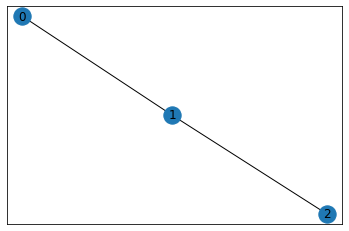

In [158]:
G = nx.path_graph(3)
print('Radius: ', nx.radius(G))
print('Diameter: ', nx.diameter(G))
print('Average shortest path length: ', nx.average_shortest_path_length(G))
print('Average clustering coefficient: ', nx.average_clustering(G))
nx.draw_networkx(G)

Radius:  2
Diameter:  3
Average shortest path length:  1.6666666666666667
Average clustering coefficient:  0.0


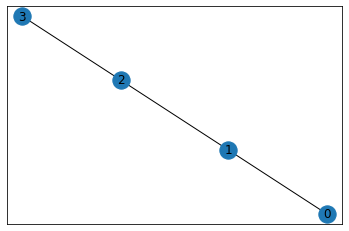

In [164]:
G = nx.path_graph(4)
print('Radius: ', nx.radius(G))
print('Diameter: ', nx.diameter(G))
print('Average shortest path length: ', nx.average_shortest_path_length(G))
print('Average clustering coefficient: ', nx.average_clustering(G))
nx.draw_networkx(G)

Your task is to create graphs by given statistics. We can create a graph using simple networkx interfaces. For example, we can create a graph by passing an edgelist.

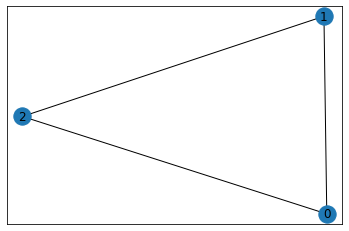

In [159]:
G = nx.Graph([[0, 1], [1, 2], [2, 0]])
nx.draw_networkx(G)

Or create an empty graph and then add edges one by one.

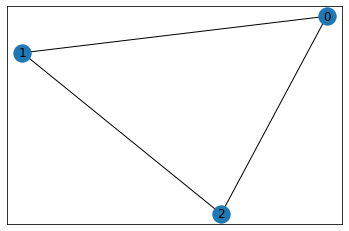

In [160]:
G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 0)
nx.draw_networkx(G)

Your task is to create graphs by given statistics.

Write a function `graph1` that returns a graph with a radius 3 and diameter 3.

In [161]:
def graph1():
    G = nx.Graph()
    G.add_edge(0, 1)
    G.add_edge(1, 2)
    G.add_edge(2, 3)
    G.add_edge(3, 4)
    G.add_edge(4, 5) 
    G.add_edge(5, 0)
    return G

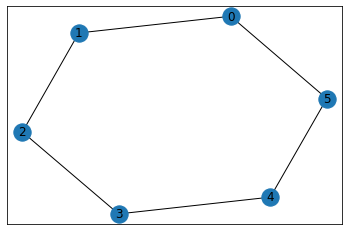

In [162]:
G = graph1()
assert nx.radius(G) == nx.diameter(G) == 3
nx.draw_networkx(G)

Write a function `graph2` that returns a graph with a diameter of at least 5 average shortest path lengths.

In [214]:
def graph2():
    n = 100
    a = [(i, i+1) for i in range(n)] + [(n, 0)]
    
    G = nx.Graph(a)
    
    for i in range(n+1):
        for j in range(n+1):
            G.add_edge(i, j)
        
    m = 6
    for j in range(m):
        G.add_edge(n+j, n+j+1)
        
    return G 

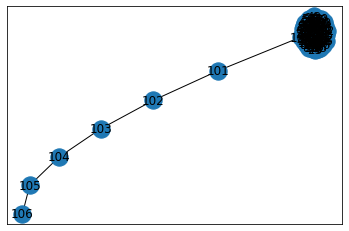

In [215]:
G = graph2()
assert nx.diameter(G) >= 5 * nx.average_shortest_path_length(G)
nx.draw_networkx(G)

Write a function `graph3` that returns a graph with an average clustering coefficient between 0.1 and 0.11.

In [281]:
def graph3():
    G = nx.Graph()
    n = 2
    a = [(i, i + 1) for i in range(n)] + [(n, 0)]
    
    G = nx.Graph(a)
    
    l = 16
    for r in range(l):
        G.add_edge(n + r, n + r + 1)
    
    
    for i in range(n + 1):
        for j in range(n + 1):
            G.add_edge(i, j)
    
    m = 3 + l
    
    for j in range(m):
        G.add_edge(n + 1 + j, n + 1 + j + 1)
    
    
    G.add_edge(n + 1, n + 1 + m)
    return G 

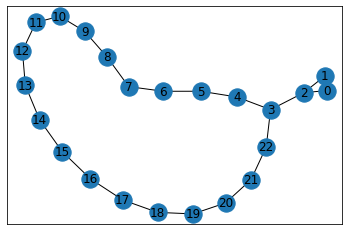

In [282]:
G = graph3()
assert 0.1 <= nx.average_clustering(G) <= 0.11
nx.draw_networkx(G)

### Task 5. Graph layout (0 points)

A graph layout is a dictionary with a location of every node: keys are nodes and values are x, y positions. By default in `nx.draw_networkx`, it is the spring layout — a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects.

In [283]:
G = nx.barabasi_albert_graph(10, 2)
layout = nx.spring_layout(G)
layout

{0: array([-0.09425276,  0.16443377]),
 1: array([ 0.09931114, -1.        ]),
 2: array([ 0.02104303, -0.47538511]),
 3: array([ 0.02365824, -0.08946174]),
 4: array([0.29410679, 0.23202893]),
 5: array([0.12547155, 0.58496799]),
 6: array([-0.44093856,  0.13266366]),
 7: array([-0.18347731,  0.69978383]),
 8: array([ 0.52695576, -0.05403143]),
 9: array([-0.37187789, -0.1949999 ])}

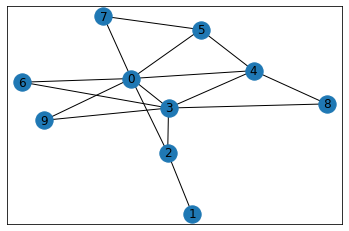

In [284]:
nx.draw_networkx(G, pos=layout)

The Kamada Kawai layout is based on path-length cost-function. Sometimes, it is quite similar to the spring layout, however a significant difference is that the spring layout is random and the Kamada Kawai is deterministic.

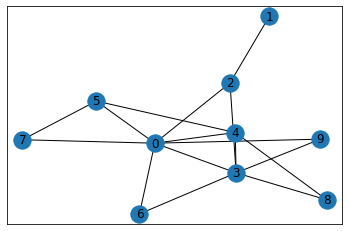

In [285]:
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=layout)

Circular layout allows to draw a graph where nodes are in a circle.

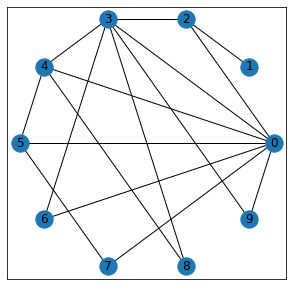

In [286]:
layout = nx.circular_layout(G)
plt.figure(figsize=(5, 5))
nx.draw_networkx(G, pos=layout)

Bipartite layout allows to draw bipartite graph.

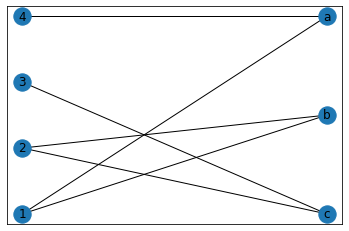

In [287]:
B = nx.Graph()
B.add_nodes_from([1, 2, 3, 4], bipartite=0)
B.add_nodes_from(["a", "b", "c"], bipartite=1)
B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")])
layout = nx.bipartite_layout(B, [1, 2, 3, 4])
nx.draw_networkx(B, pos=layout)

There are other layouts in networkx, also there are some useful parameters that you can find in documentation. Next, let us visualize a coappearance network of characters in The Matrix — a 1999 American science fiction action film written and directed by the Wachowskis. The dataset is taken from https://moviegalaxies.com/.

In [288]:
url = 'https://raw.githubusercontent.com/network-science-course/network-science-course/main/datasets/the_matrix_graph.gexf'
open('the_matrix_graph.gexf', 'wb').write(requests.get(url).content);


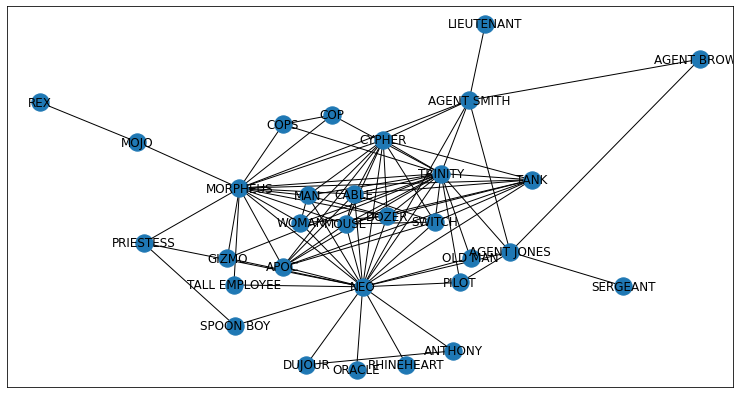

In [289]:
def get_matrix_graph():
    G = nx.read_gexf('the_matrix_graph.gexf')
    mapping = {}
    for node in G.nodes:
        mapping[node] = G.nodes[node]['label']
    G = nx.relabel_nodes(G, mapping)
    return G

matrixG = get_matrix_graph()
plt.figure(figsize=(13, 7))
layout = nx.kamada_kawai_layout(matrixG)
nx.draw_networkx(matrixG, pos=layout)

Your task is to draw the matrix graph using the kamada kawai layout with nonlinear modification to obtain a denser layout away from the NEO node. Let us define a proximity coefficient using Gaussian kernel

$$\text{coef}(i) = \exp\left(-\frac{\text{distance}^2}{2\sigma^2}\right)$$

where a _distance_ is the Euclidean distance from the node $i$ to the NEO node, $\sigma$ is the constant. Then the nodes should be moved towards the NEO node such that

$$\text{distance} = \text{coef}(i) \times \text{distance}$$

The simplest way to do it is to center the layout so that the NEO node is in x=0 y=0 and then to multiply all node positions by the proximity coefficient.

Write a function `dense_neo_layout` that takes a layout, sigma and returns a new (dense) layout.

_Hint: use `np.linalg.norm` to calculate Euclidean norm._

In [290]:
def dense_neo_layout(layout, sigma):
    ### BEGIN SOLUTION
    new_layout = {}
    for node in layout:
        new_layout[node] = layout[node] - layout['NEO']
        distance = np.linalg.norm(new_layout[node])
        coef = np.exp(-distance**2 / 2 / sigma**2)
        new_layout[node] = new_layout[node] * coef
    return new_layout
    ### END SOLUTION

In [291]:
layout = nx.kamada_kawai_layout(matrixG)
layout = dense_neo_layout(layout, sigma=1.5)
assert type(layout) == dict
assert np.all(layout['NEO'] == [0, 0])
assert np.all(layout['REX'].round(2) == [-0.67,  0.58])
assert adler32(str(layout['AGENT BROWN'].round(2)[0]).encode()) == 32309448

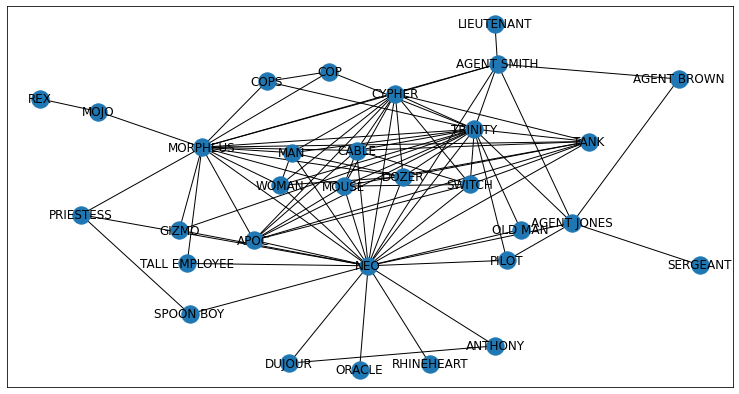

In [292]:
plt.figure(figsize=(13, 7))
nx.draw_networkx(matrixG, layout)

### Task 6. Nodes visualization (2 points)

We can set a node size using `draw_networkx` with a parameter `node_size`. It should be a list of values ordered by `G.nodes`. For example, consider a simple path graph.

In [293]:
G = nx.path_graph(3)
G.nodes

NodeView((0, 1, 2))

Let us set a size 200 for the node 0, 300 for 1, 400 for 2.

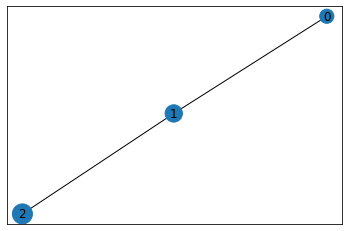

In [294]:
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=layout, node_size=[200, 300, 400])

To color nodes, we can use `node_color`. It should be a list of colors:
* a tuple of float RGB 0-1 values: (red, green, blue)
* a tuple of float RGBA 0-1 values: (red, green, blue, alpha)
* a string — color name

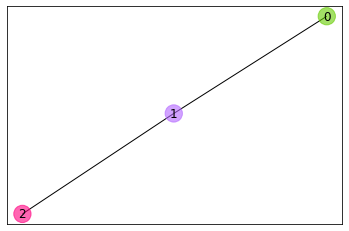

In [295]:
nx.draw_networkx(
    G,
    pos=layout,
    node_color=[(0.4, 0.8, 0, 0.6), (0.7, 0.4, 1, 0.6), (1, 0, 0.5, 0.6)])

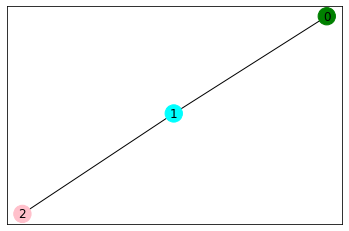

In [296]:
nx.draw_networkx(
    G,
    pos=layout,
    node_color=['green', 'cyan', 'pink'])

Also we can use a colors from matplotlib colormaps. Discrete:

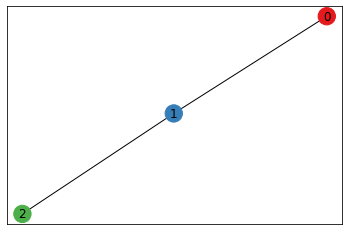

In [297]:
colors = plt.cm.Set1.colors
nx.draw_networkx(
    G,
    pos=layout,
    node_color=[colors[0], colors[1], colors[2]])

Or continuous:

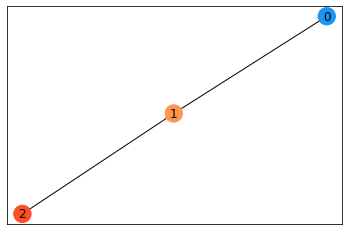

In [298]:
rainbow = plt.cm.rainbow
nx.draw_networkx(
    G,
    pos=layout,
    node_color=[rainbow(0.2), rainbow(0.8), rainbow(0.9)])

Another option of coloring nodes is to pass a list of single values by the `node_color` and colormap by the `cmap` parameter. In this case, the lowest value will assigned to the first color in colormap and vise versa.

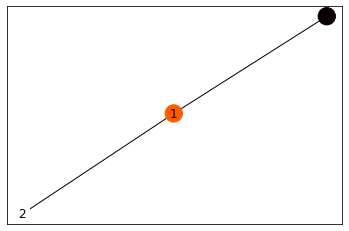

In [299]:
nx.draw_networkx(
    G,
    pos=layout,
    cmap = plt.cm.hot,
    node_color=[1, 2, 3])

We can forcibly set a color range using `vmin` and `vmax`.

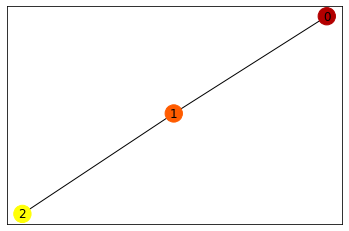

In [300]:
nx.draw_networkx(
    G,
    pos=layout,
    cmap = plt.cm.hot,
    node_color=[1, 2, 3],
    vmin=0, vmax=4)

We can border nodes using `edgecolors` and `linewidths` parameters.

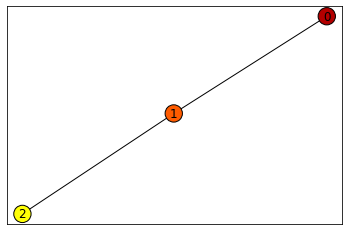

In [301]:
nx.draw_networkx(
    G=G, 
    pos=layout,
    cmap = plt.cm.hot, 
    node_color=[1, 2, 3],
    vmin=0, vmax=4, 
    edgecolors='black', 
    linewidths=1)

Your task is to adjust a size and color of nodes in the matrix graph, size and color are taken from a node degree and node attribute `G.nodes[node]`.

In [302]:
matrixG.nodes['NEO']

{'movie_id': 543,
 'Eccentricity': 3.0,
 'Closeness Centrality': 1.2666666666666666,
 'Betweenness Centrality': 197.97857142857137,
 'Degree': 23,
 'Component ID': 0,
 'Modularity Class': 2,
 'viz': {'color': {'r': 95, 'g': 202, 'b': 190, 'a': 1.0},
  'size': 20.0,
  'position': {'x': -22.198978, 'y': -24.325882, 'z': 0.0}},
 'label': 'NEO'}

Write a function `drawing_nodes_params` that takes a graph and returns a dictionary with parameters for `nx.draw_networkx` of the form `{'G': graph, 'node_color': color, ...}`. Parameters should contain a graph, kamada kawai layout, node colors from `viz.color` attribute. The colors should be converted from RGB range 0-255 to RGB range 0-1. The node size is a node degree `G.degree[node]` multiplied by 100.

In [360]:
def drawing_nodes_params(graph):
    d = {}
    d['G'] = graph  
    pos = nx.kamada_kawai_layout(graph)
    color = []
    node_size = []
    for node in graph.nodes:
        node_color = graph.nodes[node]['viz']['color']
        node_color_new = np.array([node_color['r'] / 255, 
                                   node_color['g'] / 255, 
                                   node_color['b'] / 255])

        color.append(node_color_new) 
        node_size.append(graph.degree[node] * 100)
    
    d['pos'] = pos
    d['node_color'] = color 
    d['node_size'] = node_size 
    
    return d
    

In [361]:
matrixG = get_matrix_graph() 
params = drawing_nodes_params(matrixG)
assert type(params) == dict
keys = ['G', 'pos', 'node_color', 'node_size']
assert len(set(params.keys()).intersection(keys)) == 4
assert np.all(params['node_color'][10].round(2) == [0.37, 0.79, 0.75])
assert adler32(str(params['node_color'][0][1].round(2)).encode()) == 19071123
assert params['node_size'][0] == 200
assert params['node_size'][1] == 600
assert nx.to_numpy_array(params['G']).sum() == 326.0

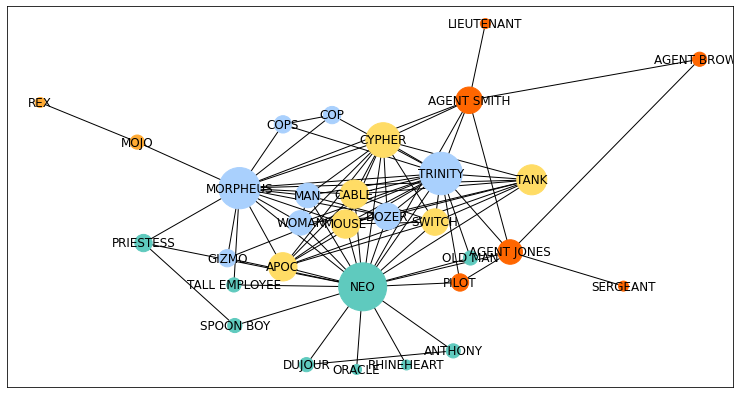

In [362]:
plt.figure(figsize=(13, 7))
nx.draw_networkx(**params )

Sometimes, it will be useful to draw nodes in nonlinear scale. If we want to make node sizes more comparable, we can use polynomial or exponential scale. On the other hand, we can use logarithmic scale to make sizes more similar.

Write a function `drawing_nodes_polyparams` that returns the same dictionary as the `drawing_nodes_params` function, but the node size is a sum of node degree in a power 3 and 10.

$$\text{size} = \text{degree}^3 + 10$$

In [366]:
def drawing_nodes_polyparams(graph):
    params = drawing_nodes_params(graph)
    node_size = []
    for node in graph.nodes: 
        node_size.append(graph.degree[node] ** 3 + 10) 
    
    params['node_size'] = node_size 
    
    return params


In [367]:
matrixG = get_matrix_graph()
params = drawing_nodes_polyparams(matrixG)
assert type(params) == dict
keys = ['G', 'pos', 'node_color', 'node_size']
assert len(set(params.keys()).intersection(keys)) == 4
assert np.all(params['node_color'][10].round(2) == [0.37, 0.79, 0.75])
assert adler32(str(params['node_color'][0][1].round(2)).encode()) == 19071123
assert params['node_size'][0] == 18
assert params['node_size'][1] == 226
assert nx.to_numpy_array(params['G']).sum() == 326.0

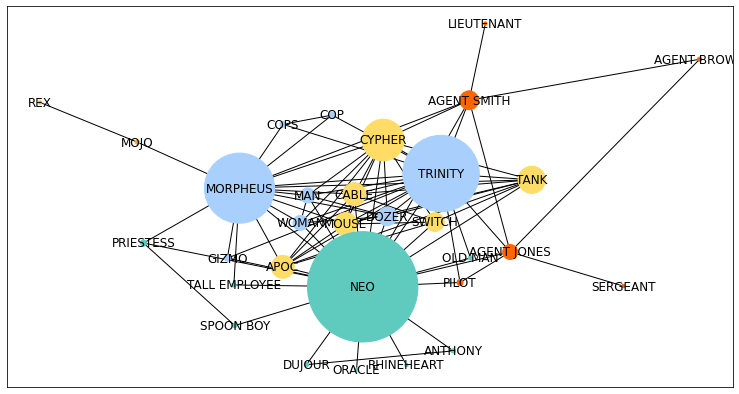

In [368]:
plt.figure(figsize=(13, 7))
nx.draw_networkx(**params )

### Task 7. Weighted graphs (1 points)

We can set an edge width using `draw_networkx` with a parameter `width`. It should be a list of values sorted by G.edges. For example, consider a simple path graph.

In [369]:
G = nx.path_graph(4)
G.edges

EdgeView([(0, 1), (1, 2), (2, 3)])

Let us set a width 1 for the edge 0-1, 5 for 1-2, 10 for 2-3.

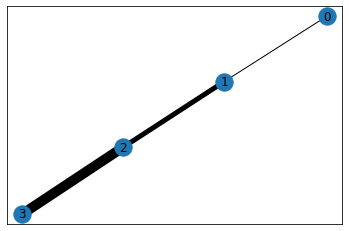

In [370]:
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=layout, width=[1, 5, 10])

If we create a graph by a weighted ajacency matrix, weights will be stored in an edge attribute `weight`.

In [371]:
W = np.array([[0, 1, 0, 0], 
              [1, 0, 5, 0], 
              [0, 5, 0, 10], 
              [0, 0, 10, 0]])
G = nx.from_numpy_array(W)

In this case, we can get a value using `G.edges[edge]` view

In [374]:
G.edges[(1, 2)]

{'weight': 5}

In [372]:
G.edges[(0, 1)]

{'weight': 1}

Or we can get all values using `nx.get_edge_attributes`

In [375]:
nx.get_edge_attributes(G, 'weight')

{(0, 1): 1, (1, 2): 5, (2, 3): 10}

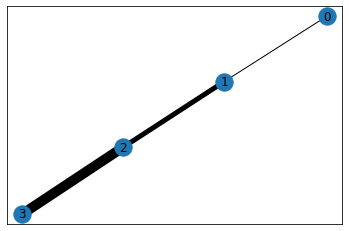

In [376]:
weights = list(nx.get_edge_attributes(G, 'weight').values())
nx.draw_networkx(G, pos=layout, width=weights)

If we want to apply specific color or style to some edges, it is possible by `edge_color` and `style` parameters. For example, we can draw an edge with a weight 10 as a red dotted line.

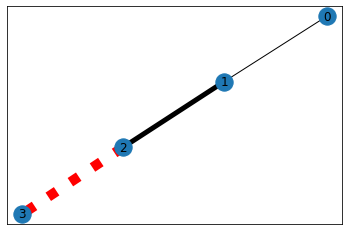

In [377]:
nx.draw_networkx(
    G, pos=layout, 
    width=[1, 5, 10], 
    edge_color=['black', 'black', 'red'], 
    style=['solid', 'solid', 'dotted'])

Your task is to draw the matrix graph where an edge width is 0 if a weight is 1, otherwise it is a weight value itself. An edge color is `red` if weight is at least 5 and `black` otherwise.

In [390]:
def drawing_edges_params(graph):
    params = drawing_nodes_polyparams(graph)
    width = []
    edge_color = []
    for edge in graph.edges: 
        edge_weight = graph.edges[edge]['weight']
        edge_width = 0 if edge_weight == 1 else edge_weight
        width.append(edge_width)
        color = 'red' if edge_weight >= 5 else 'black'
        edge_color.append(color)
        
    params['width'] = width 
    params['edge_color'] = edge_color

    return params 

In [392]:
matrixG = get_matrix_graph()
params = drawing_edges_params(matrixG)
assert type(params) == dict
keys = ['G', 'pos', 'edge_color', 'width']
assert len(set(params.keys()).intersection(keys)) == 4
assert nx.to_numpy_array(params['G']).sum() == 326.0
params['width'][0] == 2.0
assert np.array(params['width']) @ params['width'] == 508
assert adler32(str(params['edge_color']).encode()) == 646700613

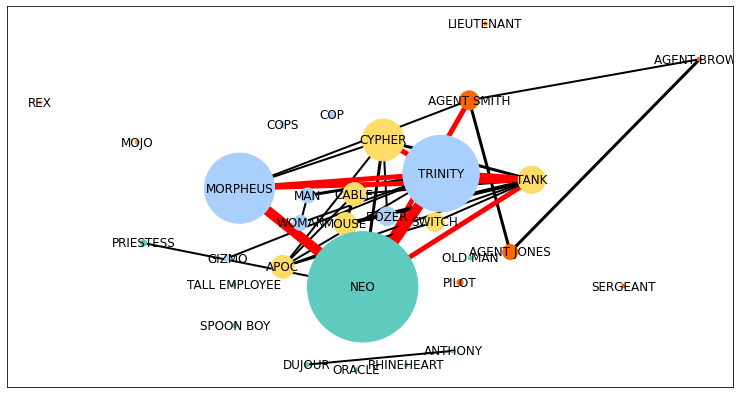

In [393]:
plt.figure(figsize=(13, 7))
nx.draw_networkx(**params)

### Task 8. Labels visualization (2 points)

In this task, we will modify some label parameters: font size, position, visibility. In networkx, we cannot pass a list of font sizes to `draw_networkx`, so we will use drawing by layers using other methods:
* `draw_networkx_nodes` — draw the nodes only
* `draw_networkx_edges` — draw the edges only
* `draw_networkx_labels` — draw the node labels only
* `draw_networkx_edge_labels` — draw the edge labels only

Also we can separately adjust an `alpha` value for nodes, edges, labels. Here is a simple example, let us draw a path graph with 4 nodes where the node 0 is labeled as "a", 3 is "b", the edge 1-2 is labeled as "edge", and edges are transparent with `alpha=0.2`.

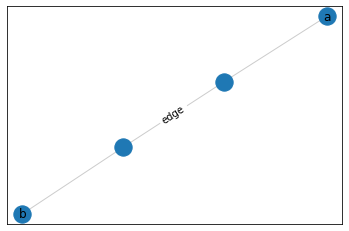

In [394]:
G = nx.path_graph(4)
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos=layout)
nx.draw_networkx_edges(G, pos=layout, alpha=0.2)

nx.draw_networkx_labels(G, pos=layout, labels={0: 'a', 3: 'b'})

nx.draw_networkx_edge_labels(G, pos=layout, edge_labels={(1, 2): 'edge'})
plt.show()

If we want to adjust a font size, it is possible by repeated drawing labels with different `font_size` values. For example:

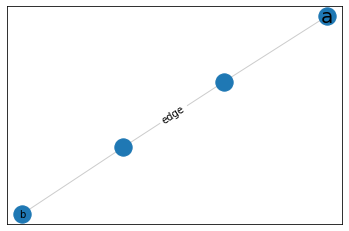

In [395]:
G = nx.path_graph(4)
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos=layout)
nx.draw_networkx_edges(G, pos=layout, alpha=0.2)
nx.draw_networkx_labels(G, pos=layout, labels={3: 'b'}, font_size=10)
nx.draw_networkx_labels(G, pos=layout, labels={0: 'a'}, font_size=20)
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels={(1, 2): 'edge'})
plt.show()

Your task is to draw the matrix graph with settings: 
* labels are invisible if a node degree less than 6
* a font size is a node degree
* all labels are slided down so that $y = y - 0.025 \sqrt{\text{degree}}$

Write a function `labels_list_parameters` that takes a graph, layout and returns a list of parameters for repeated drawing labels using `nx.draw_networkx_labels`. Each element of the list is a dictionary that can be passed to `nx.draw_networkx_labels`. The first dictionary is for the node degree 6, the second is for 7 and so on.

In [547]:
def merge_lists_of_dicts(l):
    new_l = []
    new_l.append(l[0])
      
    for d in l:
        found_font_size_like_d = False 
        for new_d in new_l:
            if d['font_size'] == new_d['font_size']:
                found_font_size_like_d = True  
                new_d['labels'].update(d['labels'])
    
        if not found_font_size_like_d:
            new_l.append(d)
    
    return new_l
    


def labels_list_parameters(graph, layout):
    list_params = []
    new_layout = {}
    
    for node in graph.nodes:
        if graph.degree[node] < 6: 
            continue
    
        list_params.append({'labels': {node: node}, 'font_size': graph.degree[node]})
        
        
    new_list_params = merge_lists_of_dicts(list_params)
    
    
    for node in graph.nodes:
        x, y = layout[node]
        new_layout[node] = np.array([x, y- 0.025 * np.sqrt(graph.degree[node])])
    
    for params in new_list_params:
        params['G'] = graph
        params['pos'] = new_layout 

    
    return sorted(new_list_params, key=lambda d: d['font_size']) 
        
        

In [548]:
matrixG = get_matrix_graph()
layout = nx.kamada_kawai_layout(matrixG)
list_params = labels_list_parameters(matrixG, layout)
assert type(list_params) == list
assert type(list_params[0]) == dict
assert len(list_params) == 8
assert nx.to_numpy_array(list_params[0]['G']).sum() == 326
assert list_params[0]['font_size'] == 6
assert adler32(str(np.array(list_params[7]['font_size'])).encode()) == 10027110
assert np.all(list_params[0]['pos']['MAN'].round(2) == [-0.16, 0.05])
assert adler32(
    str(list_params[0]['pos']['AGENT JONES'].round(2)[1]).encode()) == 46465263
assert adler32(
    str(list_params[7]['pos']['NEO'].round(2)[1]).encode()) == 46792946
assert list_params[1]['labels']['AGENT SMITH'] == 'AGENT SMITH'
assert list_params[1]['labels'].get('AGENT JONES') is None \
    or list_params[1]['labels']['AGENT JONES'] == ''
assert len([val for val in  list_params[2]['labels'].values() if val != '']) == 3

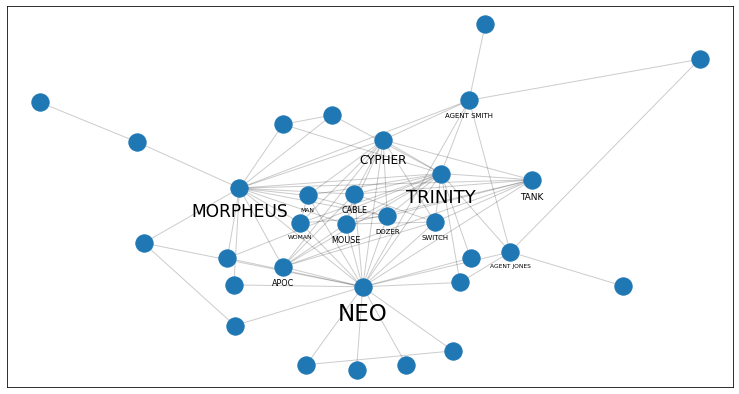

In [549]:
plt.figure(figsize=(13, 7))
layout = nx.kamada_kawai_layout(matrixG)
nx.draw_networkx_nodes(matrixG, pos=layout)
nx.draw_networkx_edges(matrixG, pos=layout, alpha=0.2)
for params in labels_list_parameters(matrixG, layout):
    nx.draw_networkx_labels(**params)
plt.show()

### Task 9. Visible area (2 points)

Drawing a large graph, it may be useful to zoom in an area near some nodes by `plt.xlim(x_min, x_max)` and `plt.ylim(y_min, y_max)` where `x_max` is a right border, `y_max` is a top border. 

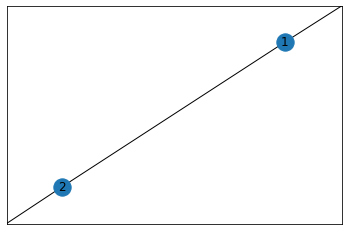

In [550]:
G = nx.path_graph(4)
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=layout)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.show()

Let us adjust a visible area and combine previous drawing techniques to get a more meaningful figure:
* take a node color from the `viz.color` node attribute converting 0-255 range to 0-1 range
* set a node size as $5\times\text{degree}^2$
* take an edge width from the `weight` edge attribute
* set an edge alpha is 0.2
* labels are invisible if a node degree less than 6
* set a font size as $3 \times \text{degree}^{2/3}$
* set a visible area such that a lower border is NEO, higher is AGENT SMITH, left is MORPHEUS, right is TANK.

Write a function `get_all_params` that takes a graph and layout and returns a dictionary with keys:
* `nodes_params` — dict, parameters for `nx.draw_networkx_nodes`
* `edges_params` — dict, parameters for `nx.draw_networkx_edges`
* `labels_param_list` — list of dict, parameters for `nx.draw_networkx_edges`, for degrees 6, 7 and so on
* `area` — list of float vlues: a left, right, lower, higher borders of the visible area

In [583]:
def new_drawing_nodes_polyparams(graph):
    params = drawing_nodes_params(graph)
    node_size = []
    for node in graph.nodes: 
        node_size.append(graph.degree[node] ** 2 * 5) 
    
    params['node_size'] = node_size 
    
    return params


def new_drawing_edges_params(graph):
    params = drawing_nodes_polyparams(graph)
    width = []
    edge_color = []
    for edge in graph.edges: 
        edge_weight = graph.edges[edge]['weight']
        edge_width = edge_weight
        width.append(edge_width)
        color = 'red' if edge_weight >= 5 else 'black'
        edge_color.append(color)
        
    params['width'] = width 
    params['edge_color'] = edge_color
    params['alpha'] = 0.2 

    return params 


def new_labels_list_parameters(graph, layout):
    list_params = []
    new_layout = {}
    
    for node in graph.nodes:
        if graph.degree[node] < 6: 
            continue
    
        list_params.append({'labels': {node: node}, 'font_size': 3*graph.degree[node]**(2/3)})
        
        
    new_list_params = merge_lists_of_dicts(list_params)
    
    
    for node in graph.nodes:
        x, y = layout[node]
        new_layout[node] = np.array([x, y])
    
    for params in new_list_params:
        params['G'] = graph
        params['pos'] = new_layout 

    
    return sorted(new_list_params, key=lambda d: d['font_size']) 


def get_all_params(graph, layout):

    edges_params = new_drawing_edges_params(graph) 
    nodes_params = new_drawing_nodes_polyparams(graph)
    labels_param_list = new_labels_list_parameters(graph, layout)
    
    lower = layout['NEO'][1]
    higher = layout['AGENT SMITH'][1]
    left = layout['MORPHEUS'][0]
    right = layout['TANK'][0]
    
    
    return {'nodes_params': nodes_params, 
            'edges_params': edges_params, 
            'labels_param_list': labels_param_list, 
            'area': [left, right, lower, higher]}


In [584]:
matrixG = get_matrix_graph()
layout = nx.kamada_kawai_layout(matrixG)
all_params = get_all_params(matrixG, layout)
assert type(all_params) == dict
keys = ['nodes_params', 'edges_params', 'labels_param_list', 'area']
assert len(set(all_params.keys()).intersection(keys)) == 4
assert nx.to_numpy_array(all_params['nodes_params']['G']).sum() == 326
assert np.all(all_params['nodes_params']['pos']['NEO'].round(2) == [0., -0.3])
assert np.all(all_params['nodes_params']['node_color'][4].round(2) == [1., 0.86, 0.4])
assert all_params['nodes_params']['node_size'][10] == 20
assert nx.to_numpy_array(all_params['edges_params']['G']).sum() == 326
assert np.all(all_params['edges_params']['pos']['NEO'].round(2) == [0. , -0.3])
assert all_params['edges_params']['alpha'] == 0.2
assert all_params['edges_params']['width'][20] == 2
assert type(all_params['labels_param_list']) == list
assert nx.to_numpy_array(all_params['labels_param_list'][0]['G']).sum() == 326
assert np.all(all_params['labels_param_list'][5]['pos']['NEO'].round(2) == [0. , -0.3])
assert all_params['labels_param_list'][5]['labels'].get('WOMAN') is None \
    or all_params['labels_param_list'][5]['labels']['WOMAN'] == ''
assert round(all_params['labels_param_list'][2]['font_size'], 4) == 12
assert all_params['area'][0] < all_params['area'][1]
assert all_params['area'][2] < all_params['area'][3]

In [586]:
all_params['edges_params']

{'G': <networkx.classes.graph.Graph at 0x7fd13851b898>,
 'pos': {'AGENT BROWN': array([1.        , 0.72182487]),
  'AGENT JONES': array([ 0.43773376, -0.14414261]),
  'AGENT SMITH': array([0.3159179 , 0.53759273]),
  'ANTHONY': array([ 0.26869011, -0.58832241]),
  'APOC': array([-0.23714204, -0.21066177]),
  'CABLE': array([-0.02486165,  0.11581847]),
  'COP': array([-0.09091204,  0.47104238]),
  'COPS': array([-0.23667809,  0.42931649]),
  'CYPHER': array([0.06077407, 0.3589168 ]),
  'DOZER': array([0.07290801, 0.01605063]),
  'DUJOUR': array([-0.16703379, -0.65025647]),
  'GIZMO': array([-0.40185577, -0.17189284]),
  'LIEUTENANT': array([0.36403407, 0.88208525]),
  'MAN': array([-0.16344735,  0.10987272]),
  'MOJO': array([-0.66927251,  0.3496258 ]),
  'MORPHEUS': array([-0.36574202,  0.14264798]),
  'MOUSE': array([-0.0508597 , -0.01854517]),
  'NEO': array([-8.35658924e-05, -3.00546822e-01]),
  'OLD MAN': array([ 0.31993997, -0.17107777]),
  'ORACLE': array([-0.01829011, -0.6720148

TypeError: draw_networkx_edges() got an unexpected keyword argument 'node_color'

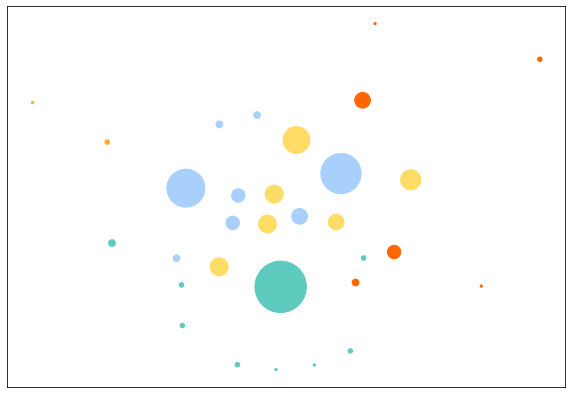

In [585]:
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
for params in all_params['labels_param_list']:
    nx.draw_networkx_labels(**params)
plt.xlim(all_params['area'][0] - 0.15, all_params['area'][1] + 0.1)
plt.ylim(all_params['area'][2] - 0.10, all_params['area'][3] + 0.1)
plt.show()